In [261]:
import numpy as np
import matplotlib.pyplot as plt


def LCG(m, a, c, x0, N):
    """
    Input:
    m, a, c are parameters of the LCG.
    x0: the initial pseduo-random number.
    N : number of random numbers to return

    Output:
    a list or numpy array of length N, containing the next
    N pseduo-random numbers in order (excluding x0).
    """

    output = np.zeros(N + 1)
    output[0] = x0

    for i in range(1, N + 1):
        output[i] = (a * output[i - 1] + c) % m

    return output[1:]


def GaussianRNG(m, a, c, x0, N):
    """
    Input:
    m, a, c, x0 are parameters of the LCG.
    N : number of Gaussian random numbers to return

    Output:
    a list or numpy array of length N, containing the next N
    Gaussian pseduo-random numbers in order (excluding x0).
    """

    uniform = LCG(m, a, c, x0, 2 * N) / m

    output = np.zeros(N)

    for i in range(N):
        output[i] = np.sqrt(-2 * np.log(uniform[2 * i])) * np.sin(
            2 * np.pi * uniform[2 * i + 1]
        )

    return output


def CheckRandomNumbers(rand_array, NB):
    """
    Input:
    rand_array: array of size N-by-d, so (rand_array[0][0], rand_array[0][1],
                rand_array[0][2]) is the first 3D point
    NB: number of bins per dimension (for 3D we need NB*NB*NB bins in total)

    Output:
    the chi-squared value of the rand_array,
    using NB**d evenly spaced bins each in [0,1).
    """

    N = rand_array.shape[0]
    d = rand_array.shape[1]
    n = N / NB**d

    counts, edges = np.histogramdd(rand_array, bins=NB, range=[[0, 1]] * d)

    chi2 = np.sum((counts - n) ** 2 / n)

    return chi2


def ComputeIntegralMidpoint(func, L, N):
    """
    Input:
    func: function with a single input f(x)
    L: sets the bounds of the integral by [-L, L]
    N: number of rectangles

    Output:
    the integral using rectangle rule
    """

    dx = 2 * L / N
    x = -L + dx / 2
    s = 0

    while x <= L:
        s += func(x) * dx

        x += dx

    return s


def ComputeIntegralMC(func, alpha, N):
    """
    Input:
    func: a well defined function that decays fast when |x| goes to infinity
    alpha: variance of the normal distribution to be sampled
    N: length of Gaussian random numbers

    Output:
    a two-element list or numpy array, with the first element being the estimate of
    the integral, and the second being the the estimate of the variance
    """

    m = 2**32
    a = 69069
    c = 1
    x0 = 0

    # Multiply Gaussian random numbers by np.sqrt(alpha)
    # to make their variance equal to alpha
    gaussian_arrays = np.sqrt(alpha) * np.array(GaussianRNG(m, a, c, x0, N))

    # PDF of the normal distribution
    def p(x, alpha):
        return np.exp(-x * x / (2.0 * alpha)) / np.sqrt(2.0 * np.pi * alpha)

    fx = func(gaussian_arrays)
    px = p(gaussian_arrays, alpha)

    gx = fx / px
    mean = np.mean(gx)
    variance = np.var(gx)
    return mean, variance

### 1.

It takes a period of 8 numbers before the LCG repeats. Not all numbers between [0, m-1] are generated becausse m is divisible by 4 and a - 1 is not.

In [262]:
print(LCG(16, 3, 1, 2, 16).astype(int))

[ 7  6  3 10 15 14 11  2  7  6  3 10 15 14 11  2]


### 2.

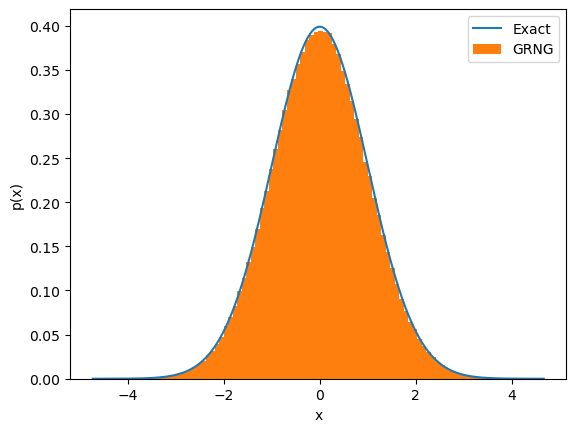

In [263]:
def pdf(x):
    return np.exp(-(x**2) / 2) / np.sqrt(2 * np.pi)


m = 2**32
a = 69069
c = 1
x0 = 1
N = 1000000

gaussian_arrays = np.array(GaussianRNG(m, a, c, x0, N))
exact = pdf(gaussian_arrays)
sort = np.argsort(gaussian_arrays)

plt.plot(gaussian_arrays[sort], exact[sort], label="Exact")
# plt.hist(gaussian_arrays, bins=100, density=True, label="GRNG")

L = np.max(np.abs(gaussian_arrays))
counts, bins = np.histogram(gaussian_arrays, bins=100)
counts = counts * 100 / (2 * N * L)
plt.hist(bins[:-1], bins, weights=counts, label="GRNG")

plt.legend()
plt.xlabel("x")
plt.ylabel("p(x)")
plt.show()

### 3.

In [266]:
from scipy.stats import chi2

m = 2**32
a = 69069
c = 1
x0 = 0

N_1d = 12000
NB_1d = 100
uniform_1d = LCG(m, a, c, x0, N_1d) / m
chi_1d = CheckRandomNumbers(uniform_1d.reshape(-1, 1), NB_1d)
p_1d = chi2.cdf(chi_1d, 99)

print("1D:")
print(f"\t LCG parameters: m = {m}, a = {a}, c = {c}, x0 = {x0}, N = {N_1d}")
print(
    f"\t 1D chi-squared: {np.round(chi_1d, 2)},",
    f"1D lower tail probability: {np.round(p_1d,2)} \n",
)

N_2d = 6000
NB_2d = 10
uniform_2d = LCG(m, a, c, x0, N_2d * 2).reshape(-1, 2) / m
chi_2d = CheckRandomNumbers(uniform_2d, NB_2d)
p_2d = chi2.cdf(chi_2d, NB_2d**2 - 1)
print("2D:")
print(f"\t LCG parameters: m = {m}, a = {a}, c = {c}, x0 = {x0}, N = {N_2d}")
print(
    f"\t 2D chi-squared: {np.round(chi_2d,2)},",
    f"2D lower tail probability: {np.round(p_2d,2)}\n",
)

N_3d = 6000
NB_3d = 10
uniform_3d = LCG(m, a, c, x0, N_3d * 3).reshape(-1, 3) / m
chi_3d = CheckRandomNumbers(uniform_3d, NB_3d)
p_3d = chi2.cdf(chi_3d, NB_3d**3 - 1)
print("3D:")
print(f"\t LCG parameters: m = {m}, a = {a}, c = {c}, x0 = {x0}, N = {N_3d}")
print(
    f"\t 3D chi-squared: {np.round(chi_3d,2)},",
    f"3D lower tail probability: {np.round(p_3d,2)}",
)

1D:
	 LCG parameters: m = 4294967296, a = 69069, c = 1, x0 = 0, N = 12000
	 1D chi-squared: 87.8, 1D lower tail probability: 0.22 

2D:
	 LCG parameters: m = 4294967296, a = 69069, c = 1, x0 = 0, N = 6000
	 2D chi-squared: 91.33, 2D lower tail probability: 0.3

3D:
	 LCG parameters: m = 4294967296, a = 69069, c = 1, x0 = 0, N = 6000
	 3D chi-squared: 1026.33, 3D lower tail probability: 0.73


Each case passes the $\chi^2$ test since each lower tail p-value is less than $0.90$.

In [267]:
import random

random.seed(0)
uniform_1d_python = np.zeros(N_1d)
for i in range(N_1d):
    uniform_1d_python[i] = random.random()

uniform_1d_python = uniform_1d_python.reshape(-1, 1)
chi_1d_python = CheckRandomNumbers(uniform_1d_python, NB_1d)
p_1d_python = chi2.cdf(chi_1d_python, NB_1d - 1)

print(f"Python random(): \n")
print("1D:")
print(
    f"\t 1D chi-squared: {np.round(chi_1d_python, 2)},",
    f"1D lower tail probability: {np.round(p_1d_python,2)} \n",
)

random.seed(0)
uniform_2d_python = np.zeros(N_2d * 2)
for i in range(N_2d * 2):
    uniform_2d_python[i] = random.random()

uniform_2d_python = uniform_2d_python.reshape(-1, 2)
chi_2d_python = CheckRandomNumbers(uniform_2d_python, NB_2d)
p_2d_python = chi2.cdf(chi_2d_python, NB_2d**2 - 1)

print("2D:")
print(
    f"\t 2D chi-squared: {np.round(chi_2d_python,2)},",
    f"2D lower tail probability: {np.round(p_2d_python,2)}\n",
)

random.seed(0)
uniform_3d_python = np.zeros(N_3d * 3)
for i in range(N_3d * 3):
    uniform_3d_python[i] = random.random()

uniform_3d_python = uniform_3d_python.reshape(-1, 3)
chi_3d_python = CheckRandomNumbers(uniform_3d_python, NB_3d)
p_3d_python = chi2.cdf(chi_3d_python, NB_3d**3 - 1)

print("3D:")
print(
    f"\t 3D chi-squared: {np.round(chi_3d_python,2)},",
    f"3D lower tail probability: {np.round(p_3d_python,2)}",
)

Python random(): 

1D:
	 1D chi-squared: 107.98, 1D lower tail probability: 0.75 

2D:
	 2D chi-squared: 96.93, 2D lower tail probability: 0.46

3D:
	 3D chi-squared: 961.67, 3D lower tail probability: 0.2


Each case passes the $\chi^2$ test since each lower tail p-value is less than $0.90$.

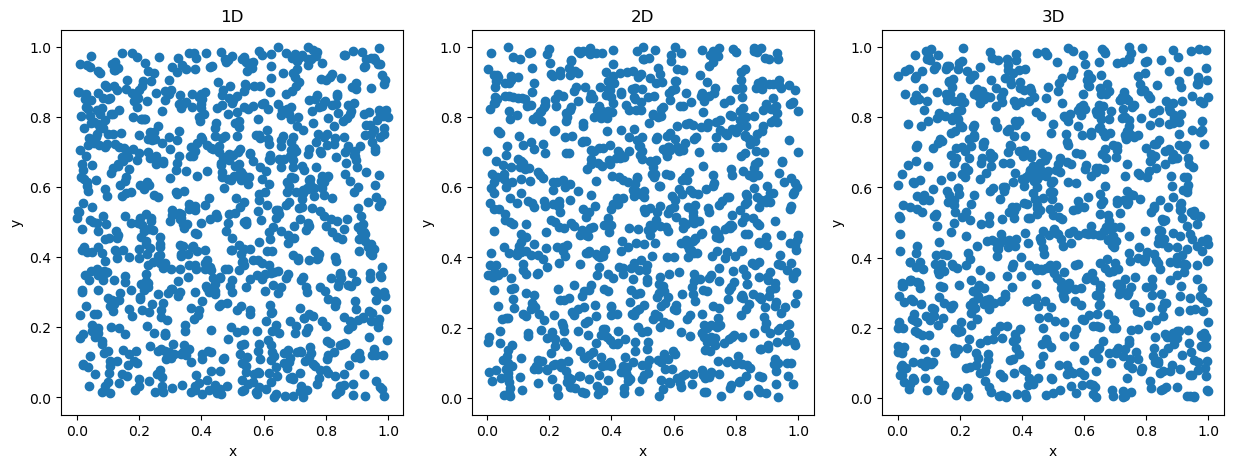

In [268]:
data_1d = np.loadtxt("data/1D_chi_squared_data_set_1.txt")
data_1d = data_1d.reshape(-1, 2)
data_1d = data_1d[:1000]

data_2d = np.loadtxt("data/2D_chi_squared_data_set_1.txt")
data_2d = data_2d[:1000]

data_3d = np.loadtxt("data/3D_chi_squared_data_set_1.txt")
data_3d = data_3d[:1000]
data_3d = data_3d[:, :2]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(data_1d[:, 0], data_1d[:, 1])
axes[0].set_title("1D")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

axes[1].scatter(data_2d[:, 0], data_2d[:, 1], label="2D")
axes[1].set_title("2D")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")

axes[2].scatter(data_3d[:, 0], data_3d[:, 1], label="3D")
axes[2].set_title("3D")
axes[2].set_xlabel("x")
axes[2].set_ylabel("y")
plt.show()

### 4.

We can choose L to be 10, as the probability of observing values outside of $\pm$ 10 is approximately 0. Further, the correct normalization factor $\Omega$ is $\frac{2L}{N}$

### 5.

In [184]:
def f(x):
    return np.exp(-(x**2) / 2) / (1 + x**2)


N = 10000
res_midpt = ComputeIntegralMidpoint(f, 10, 1000)
print(np.round(res_midpt, 4))

1.6435


### 6.

$K = \frac{1}{\sqrt{2.0 \pi \alpha}}$

### 7.

$f(x) = \frac{1}{1 + x^{2}}e^{-x^{2}/2}$

$p(x) = \frac{1}{\sqrt{2 \pi \alpha}}e^{-x^{2}/2\alpha}$

$g(x) = \frac{f(x)}{p(x)} = \frac{\frac{1}{1 + x^{2}}e^{-x^{2}/2}}{\frac{1}{\sqrt{2.0 \pi \alpha}}e^{-x^{2}/2\alpha}}$

$\boxed{g(x) = \frac{\sqrt{2\pi\alpha}}{1+x^{2}}e^{-\frac{x^{2}}{2}(1-\frac{1}{\alpha})}}$

$\sigma_{I}^{2} = \langle g(x)^{2} \rangle - \langle g(x) \rangle^{2}$

$g(x)^{2} = (\frac{f(x)}{p(x)})^{2} \rightarrow \langle g(x)^{2} \rangle = \int_{-\infty}^{\infty} \frac{f(x)^{2}}{p(x)^{2}}p(x)dx = \int_{-\infty}^{\infty} \frac{f(x)^{2}}{p(x)}dx$

$\sigma_{I}^{2} = \int_{-\infty}^{\infty} \frac{f(x)^{2}}{p(x)}dx - \int_{-\infty}^{\infty} \frac{f(x)}{p(x)}p(x)dx \int_{-\infty}^{\infty} \frac{f(x)}{p(x)}p(x)dx$

$\boxed{\sigma_{I}^{2} = \int_{-\infty}^{\infty} \frac{\sqrt{2\pi \alpha}}{(1 + x^{2})^{2}}e^{-x^{2}(1 - \frac{1}{2\alpha})}dx - I^{2}}$

Numerically, we would use the estimator $\sigma^{2}_{I} \approx E[g(x)^{2}] - E[g(x)]^{2} = \frac{1}{N}\sum_{i=1}^{N}g(x_{i})^{2} - (\frac{1}{N}\sum_{i=1}^{N}g(x_{i}))^{2}$

### 8.

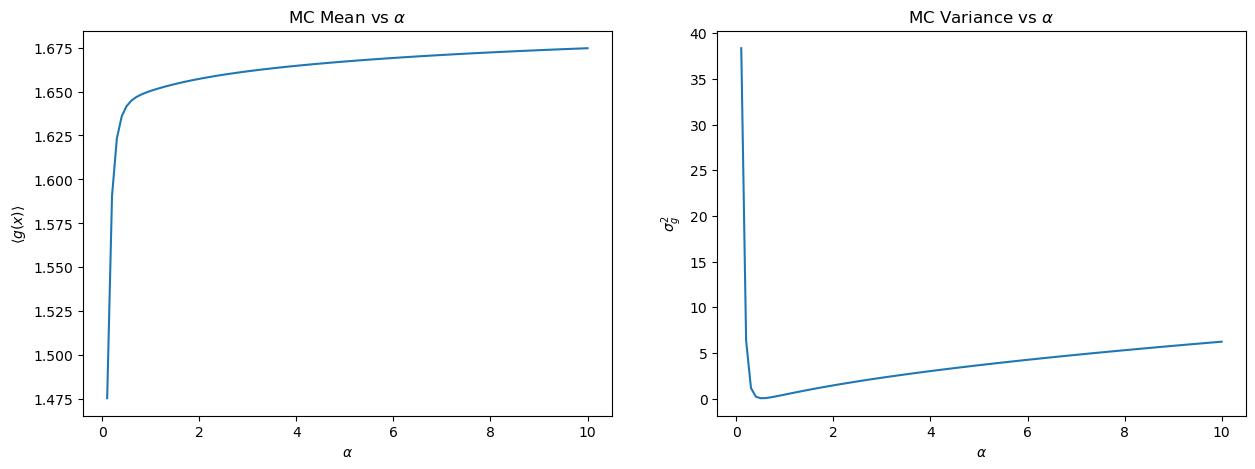

Computed mean for alpha = 2.0: I = 1.6572


In [245]:
alphas = np.linspace(0.1, 10, 100)
mc_results = np.zeros((100, 2))
N = 10000

for i, alpha in enumerate(alphas):
    res_mc = ComputeIntegralMC(f, alpha, N)
    mc_results[i] = res_mc

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(alphas, mc_results[:, 0])
axes[1].plot(alphas, mc_results[:, 1])

axes[0].set_xlabel(r"$\alpha$")
axes[0].set_ylabel(r"$\langle g(x) \rangle$")
axes[1].set_xlabel(r"$\alpha$")
axes[1].set_ylabel(r"$\sigma^{2}_{g}$")
axes[0].set_title(r"MC Mean vs $\alpha$")
axes[1].set_title(r"MC Variance vs $\alpha$")
plt.show()

print(f"Computed mean for alpha = 2.0: I = {np.round(mc_results[19,0],4)}")

### 9.

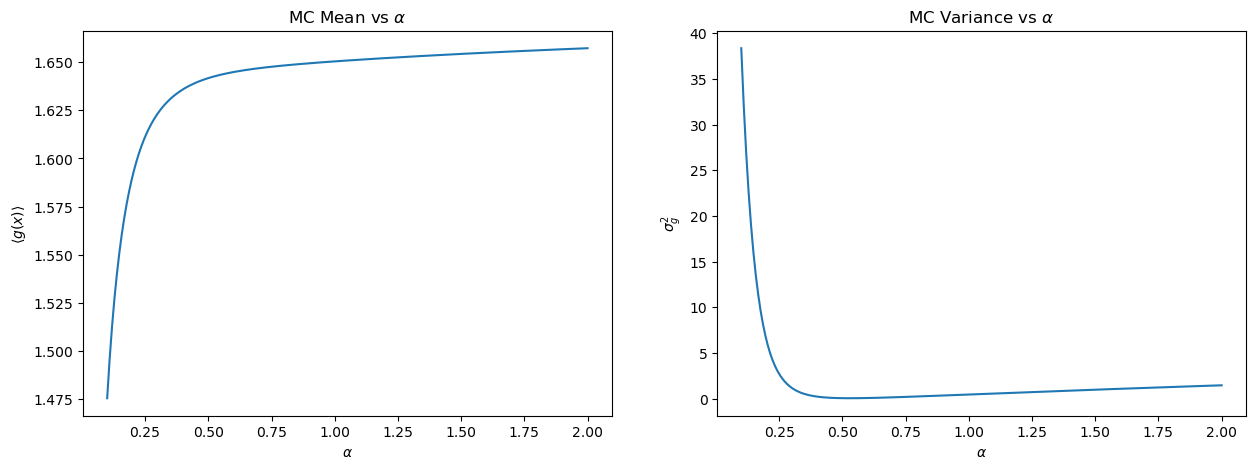

The variance-minimizing alpha is approximately 0.53


In [219]:
from numpy import argmin


alphas = np.linspace(0.1, 2, 200)
mc_results = np.zeros((200, 2))
N = 10000

for i, alpha in enumerate(alphas):
    res_mc = ComputeIntegralMC(f, alpha, N)
    mc_results[i] = res_mc

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(alphas, mc_results[:, 0])
axes[1].plot(alphas, mc_results[:, 1])

axes[0].set_xlabel(r"$\alpha$")
axes[0].set_ylabel(r"$\langle g(x) \rangle$")
axes[1].set_xlabel(r"$\alpha$")
axes[1].set_ylabel(r"$\sigma^{2}_{g}$")
axes[0].set_title(r"MC Mean vs $\alpha$")
axes[1].set_title(r"MC Variance vs $\alpha$")
plt.show()

arg = np.argmin(mc_results[:, 1])
alpha_min = np.round(alphas[arg], 2)

print(f"The variance-minimizing alpha is approximately {alpha_min}")

### 10.

Text(0, 0.5, 'Variance Ratio')

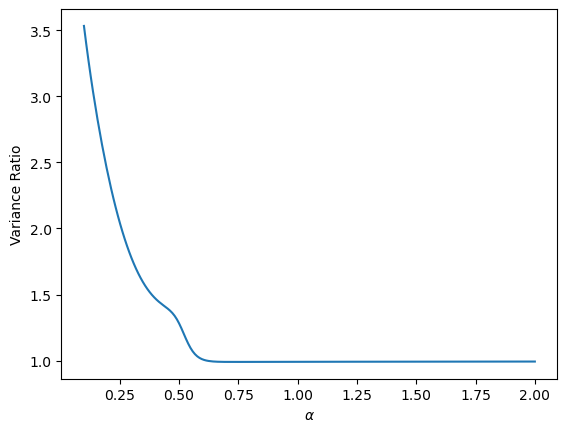

In [222]:
mc_results4 = np.zeros((200, 2))
N = 10000 * 4

for i, alpha in enumerate(alphas):
    res_mc = ComputeIntegralMC(f, alpha, N)
    mc_results4[i] = res_mc

var_ratio = mc_results4[:, 1] / mc_results[:, 1]
plt.plot(alphas, var_ratio)
plt.xlabel(r"$\alpha$")
plt.ylabel("Variance Ratio")
plt.show()

The variance begins to diverge around $\alpha = 0.5$.

### 11.

From #7, we have:

$\sigma_{I}^{2}(\alpha) = \int_{-\infty}^{\infty} \frac{\sqrt{2\pi \alpha}}{(1 + x^{2})^{2}}e^{-x^{2}(1 - \frac{1}{2\alpha})}dx - I^{2}$

Where $I = \int_{-\infty}^{\infty} \frac{1}{1 + x^{2}}e^{-x^{2}/2}dx$

Since $I$ is (analytically) independent of $\alpha$, we can neglect it in searching for discontinuities. We see in the term $e^{-x^{2}(1 - \frac{1}{2\alpha})}$ that the variance will begin to grow exponentially when $1 - \frac{1}{2\alpha} < 0 \rightarrow \alpha < 0.5$ and become infinite at $\alpha = 0$. This is consistent with the results from #10.

### 12.

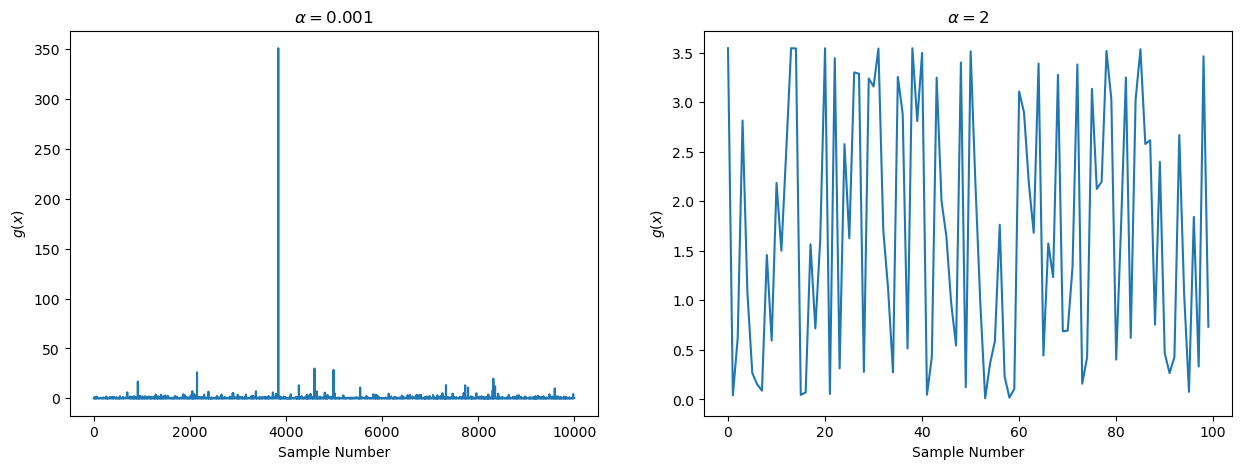

In [260]:
from matplotlib.pyplot import subplots


def g(func, alpha, N):
    """
    Input:
    func: a well defined function that decays fast when |x| goes to infinity
    alpha: variance of the normal distribution to be sampled
    N: length of Gaussian random numbers

    Output:
    g(x) estimator of f(x) evaluated at each of the N Gaussian random numbers
    """

    m = 2**32
    a = 69069
    c = 1
    x0 = 0

    # Multiply Gaussian random numbers by np.sqrt(alpha)
    # to make their variance equal to alpha
    gaussian_arrays = np.sqrt(alpha) * np.array(GaussianRNG(m, a, c, x0, N))

    # PDF of the normal distribution
    def p(x, alpha):
        return np.exp(-x * x / (2.0 * alpha)) / np.sqrt(2.0 * np.pi * alpha)

    fx = func(gaussian_arrays)
    px = p(gaussian_arrays, alpha)

    gx = fx / px

    return gx


inf_var = g(f, 0.001, 10000)
finite_var = g(f, 2, 100)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(inf_var)
axes[0].set_xlabel("Sample Number")
axes[0].set_ylabel(r"$g(x)$")
axes[0].set_title(r"$\alpha = 0.001$")

axes[1].plot(finite_var)
axes[1].set_xlabel("Sample Number")
axes[1].set_ylabel(r"$g(x)$")
axes[1].set_title(r"$\alpha = 2$")

plt.show()

The case with infinite variance ($\alpha \approx 0$) displays dramatic, large fluctuations in the estimate of $g(x)$, whereas the finite variance case $\alpha=2$ has more stable, lower magnitude fluctuations.